## Linear models

This notebook creates a linear model for each unique sensor. The pollution level of each sensor will be modeled based on wind characteristics and potentially other covariates. The idea is that each sensor will have coefficients on the wind direction variables, which will be directly interpretable as to the effect of wind on pollution level. We can read these coefficients right out of the model specification and could for example visualize them as arrows just like we do in `naive_model`.

In [1]:
# import libraries
import pandas as pd
import numpy as np 
import warnings
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import sys
sys.path.append("../HistoricalData/")
from getData import get_data

%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
# this call to get_data function that will take bounding box and timeframe and return cleaned data

UP_LEFT = (38.008050, -122.536985)    # (lat, lon)
UP_RIGHT = (38.008050, -122.186437)   # (lat, lon)
DOWN_RIGHT = (37.701933, -122.186437) # (lat, lon)
DOWN_LEFT = (37.701933, -122.536985)  # (lat, lon)
START_DATE = '2019/09/01' # begin date to start taking data
END_DATE = '2019/09/30'   # end date to start taking data
START_HOUR = '0'         # hour EACH DAY to start, this allows us to control for time of day effects
END_HOUR = '1'           # hour EACH DAY to end, this allows us to control for time of day effects
color = "red"

data_df = get_data(UP_LEFT, UP_RIGHT, DOWN_RIGHT, DOWN_LEFT, START_DATE, END_DATE, START_HOUR, END_HOUR)

In [3]:
# remove rows with na data for 2_5um
data_df = data_df[data_df['2_5um'].notna()]

## Treating wind data categorically

In [4]:
# define direction degree range by rounding to nearest cardinal direction
# NORTH = (316,45)
# EAST = (46,135)
# SOUTH = (136,225)
# WEST = (226,315)

# tried a reduced range of only +/- 15 degrees instead of 45 degrees
NORTH = (346,15)
EAST = (76,105)
SOUTH = (166,195)
WEST = (256,285)

In [6]:
# go through the dataframe and add new categorical column that indicates direction: 
# North, South, East, West, No wind, Missing, ERROR

wind_compass = [] 
for row in range(len(data_df)):
    try:
        degree = int(data_df.loc[row].wind_direction)
    except:
        wind_compass.append('Missing')
        continue
    if data_df.loc[row].wind_speed == 0:
        wind_compass.append('No wind')
    elif degree >= NORTH[0] or degree <= NORTH[1]:
        wind_compass.append('North')
    elif degree >= EAST[0] and degree <= EAST[1]:
        wind_compass.append('East')
    elif degree >= SOUTH[0] and degree <= SOUTH[1]:
        wind_compass.append('South')
    elif degree >= WEST[0] and degree <= WEST[1]:
        wind_compass.append('West')
    else:
        wind_compass.append('ERROR')
data_df['wind_compass'] = wind_compass

#### Optional cell: balance wind classes

In [14]:
# balance wind classes by downsampling to minimum class size
# data_df.groupby('wind_compass').count()

g = data_df.groupby('wind_compass')
data_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

In [15]:
np.random.seed(0)

r2_scores = []

for sensor in data_df.sensor_id.unique():
    data_df_small = data_df[data_df.sensor_id == sensor]

    # factorize for regression
    data_df_small = data_df_small.join(pd.get_dummies(data_df_small.wind_compass))
    
    # for each sensor, get all compass directions that show up in the data (for a short time period it may not be all of them)
    cols = data_df_small.wind_compass.unique().tolist()
    # remove Missing since we don't want to model that directly.
    if 'Missing' in cols:
        cols.remove('Missing')

    # train test split and convert to numpy arrays so that sklearn likes them
    train, test = train_test_split(data_df_small, test_size=0.2)
    train_x = train[cols].to_numpy()
    train_y = train['2_5um'].to_numpy()
    test_x = test[cols].to_numpy()
    test_y = test['2_5um'].to_numpy()

    regr = LinearRegression()
    regr.fit(train_x, train_y)

    # Make predictions using the testing set
    y_predictions = regr.predict(test_x)

    # Print the coefficients
#     print('Coefficients: \n', regr.coef_)
#     # Print the mean squared error
#     print("Mean squared error: %.2f"
#           % mean_squared_error(test_y, y_predictions))
#     # Print the explained variance score: 1 is perfect prediction, 0 is equivalent to guessing the expected value each time
#     print('Variance score: %.2f' % r2_score(test_y, y_predictions))
    
    # keep a running list of the explained variance scores
    r2_scores.append(r2_score(test_y, y_predictions))

## Treating wind data as component vectors

In [16]:
# go through the dataframe and add two columns for wind component vectors: 
# North, South, East, West, No wind, Missing, ERROR

# x_wind = [] # East/West,   convention will be positive for East
# y_wind = [] # North/South, convention will be positive for North
# for row in range(len(data_df)):
#     try:
#         degree = float(data_df.loc[row].wind_direction) # 0 is North and goes CW
#     except:
#         x_wind.append('Missing')
#         y_wind.append('Missing')
#         continue
    
#     x_comp = data_df.loc[row].wind_speed * np.sin(np.deg2rad(degree))
#     y_comp = data_df.loc[row].wind_speed * np.cos(np.deg2rad(degree))
#     x_wind.append(x_comp)
#     y_wind.append(y_comp)
        
# data_df['x_wind'] = x_wind
# data_df['y_wind'] = y_wind

In [17]:
# data_df = data_df[data_df['x_wind'] != 'Missing']

In [18]:
# np.random.seed(0)

# r2_scores = []

# for sensor in data_df.sensor_id.unique():
#     data_df_small = data_df[data_df.sensor_id == sensor]

#     # train test split and convert to numpy arrays so that sklearn likes them
#     train, test = train_test_split(data_df_small, test_size=0.2)
#     train_x = train[['x_wind', 'y_wind']].to_numpy()
#     train_y = train['2_5um'].to_numpy()
#     test_x = test[['x_wind', 'y_wind']].to_numpy()
#     test_y = test['2_5um'].to_numpy()

#     regr = LinearRegression()
#     regr.fit(train_x, train_y)

#     # Make predictions using the testing set
#     y_predictions = regr.predict(test_x)

#     # Print the coefficients
# #     print('Coefficients: \n', regr.coef_)
# #     # Print the mean squared error
# #     print("Mean squared error: %.2f"
# #           % mean_squared_error(test_y, y_predictions))
# #     # Print the explained variance score: 1 is perfect prediction, 0 is equivalent to guessing the expected value each time
# #     print('Variance score: %.2f' % r2_score(test_y, y_predictions))
    
#     # keep a running list of the explained variance scores
#     r2_scores.append(r2_score(test_y, y_predictions))

## Plot results
#### Works for both categorical or component wind data

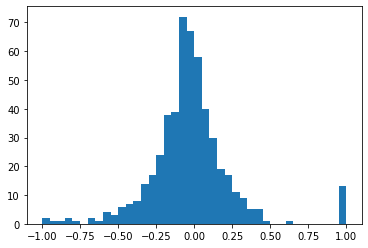

In [20]:
# plot the explained variance scores in a histogram to see if these models are making any valuable predictions
plt.hist(r2_scores, range=(-1,1), bins=40)
plt.show()